Python implementation of the Image Resolution Estimation algorithm by A. Descloux et al. 

>Descloux, A., K. S. Grußmayer, et A. Radenovic. _Parameter-Free Image Resolution Estimation Based on Decorrelation Analysis_. Nature Methods 16, nᵒ 9 (septembre 2019): 918‑24. https://doi.org/10.1038/s41592-019-0515-7.

Original source code in matlab™ and ImageJ plugin are available [here](https://github.com/Ades91/ImDecorr)


In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.signal import general_gaussian, find_peaks

from scipy.fft import fft2

from scipy.fft import fftshift, ifft2, ifftshift

from skimage import img_as_float

from skimage.io import imread, imsave

In [2]:
# apodImRect.m
def apodise(image, border, order=8):
    """
    Parameters
    ----------
    
    image: np.ndarray 
    border: int, the size of the boreder in pixels
    
    Note
    ----
    The image is assumed to be of float datatype, no datatype management
    is performed.
    
    This is different from the original apodistation method,
    which multiplied the image borders by a quater of a sine.
    """
    
    # https://stackoverflow.com/questions/46211487/apodization-mask-for-fast-fourier-transforms-in-python
    nx, ny = image.shape
    # Define a general Gaussian in 2D as outer product of the function with itself
    window = np.outer(
        general_gaussian(nx, order, nx//2-border),
        general_gaussian(ny, order, ny//2-border))
    ap_image = window*image
    
    return ap_image


In [3]:
def test_apodise():

    image = np.random.random((800, 600))
    ap_image = apodise(image, 60)
    assert ap_image.shape == image.shape
    
    assert ap_image[:, 0].mean() < 1e-3
    assert ap_image[0, :].mean() < 1e-3
    np.testing.assert_array_almost_equal(
        ap_image[400:410, 300:310],
        image[400:410, 300:310], decimal=3
    )
        

In [4]:
def get_correlation_coefficient(im_fft1, im_fft2, c1=None, c2=None):
    if c1 is None:
        c1 = np.linalg.norm(im_fft1)
    if c2 is None:
        c2 = np.linalg.norm(im_fft2)
    return (im_fft1 * im_fft2.conjugate()).real.sum() / (c1*c2)


In [5]:
def test_cor_coeff():
    im1 = np.random.random([1000, 1000])
    im2 = np.random.random([1000, 1000])
    im_fft1 = fft2(im1)
    im_fft2 = fft2(im2)
    np.testing.assert_almost_equal(
        np.linalg.norm(np.abs(im_fft1)), np.linalg.norm(im_fft1)
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, im_fft2),
        0.75, significant=2
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, im_fft1),
        1.0, significant=5
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, fft2(1 - im1)),
        0.5, significant=2
    )

test_cor_coeff()

In [7]:
corti = img_as_float(imread('../../samples/corti00.tif'))



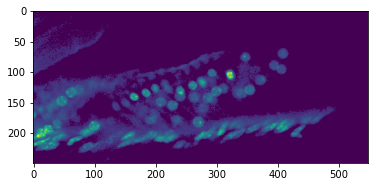

In [8]:
plt.imshow(corti)

In [9]:
corti.shape

(249, 548)

For `corti00.tif` with the official plugin:

* Resolution: 5.414 pixels
* kc : 0.369
* A0 : 0.618

In [198]:
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
from scipy.optimize import minimize_scalar


def _fft(image):
    """shifted fft
    """
    return fftshift(fft2(fftshift(image)))

def _ifft(im_fft):
    """shifted ifft
    """
    return ifftshift(ifft2(ifftshift(im_fft)))

def _masked_fft(im, mask, size):
    return (mask * _fft(im)).ravel()[:size // 2]


class ImageDecorr:
    pod_size = 30
    pod_order = 8
    
    def __init__(self, image, square_crop=True):
        """ Creates an ImageDecorr contrainer class
        
        Parameters
        ----------
        image: 2D np.ndarray
        """
        
        self.image = apodise(image, self.pod_size, self.pod_order)
        nx, ny = self.image.shape
        
        if square_crop:
            # odd number of pixels, square image
            n = min(nx, ny)
            n = n - (1 - n%2)
            self.image = self.image[:n, :n]
            self.size = n**2
            xx, yy = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
        else:
            
            nx = nx - (1 - nx%2)
            ny = ny - (1 - nx%2)
            self.image = self.image[:nx, :ny]
            self.size = nx * ny
            xx, yy = np.meshgrid(
                np.linspace(-1, 1, ny),
                np.linspace(-1, 1, nx))
        
        
        self.disk = (xx**2 + yy**2)
        self.mask0 = self.disk < 1.0
        
        im_fft0 = _fft(self.image)
        im_fft0 /= np.abs(im_fft0)
        im_fft0[~np.isfinite(im_fft0)] = 0
       
        self.im_fft0 = im_fft0 * self.mask0 # I in original code
        image_bar = (self.image - self.image.mean())/self.image.std()
        im_fftk = _fft(image_bar) * self.mask0  # Ik
        self.im_invk = _ifft(im_fftk).real # imr

        self.im_fftr = _masked_fft(self.im_invk, self.mask0, self.size) # Ir
        self.snr0, self.kc0 = self.maximize_corcoef(self.im_fftr).values() # A0, res0
        self.max_width = 2 / self.kc0
        
    def corcoef(self, radius, im_fftr, c1=None):
        """
        
        """
        mask = (self.disk < radius**2)
        f_im_fft = (mask * self.im_fft0).ravel()[: self.size//2]

        return get_correlation_coefficient(im_fftr, f_im_fft, c1=c1)
    
    def maximize_corcoef(self, im_fftr, r_min=0, r_max=1):
        
        def anti_cor(radius):
            c1 = np.linalg.norm(im_fftr)
            cor = self.corcoef(radius, im_fftr, c1=c1)
            return 1 - cor

        res = minimize_scalar(
            anti_cor,
            bounds=(r_min, r_max),
            method='bounded',
            options={"xatol": 1e-4}
        )
        
        if not res.success:
            return {"snr": 0.0, "kc": 1.0}
        
        if (r_max - res.x) / r_max < 1e-3:
            return {"snr": 0.0, "kc": r_max}
        
        return {"snr": 1 - res.fun, "kc": res.x}
    
    def all_corcoefs(self, im_fftr, num_rs, r_min=0, r_max=1, num_ws=0):
        
        radii = np.linspace(r_min, r_max, num_rs)
        c1 = np.linalg.norm(im_fftr)
        
        d0 =  np.array([
            self.corcoef(radius, im_fftr, c1=c1) for radius in radii
        ])
        if not num_ws:
            return radii, d0
        ds = [d0]
        snr, kc = self.maximize_corcoef(im_fftr, r_min, r_max).values()
        snrs = [snr]
        kcs = [kc]
        
        widths = np.concatenate([[0,], np.logspace(-1, np.log10(self.max_width), num_ws)])
        for width in widths[1:]:
            f_im = self.im_invk - gaussian_filter(self.im_invk, width)
            f_im_fft = _masked_fft(f_im, self.mask0, self.size)
            c1 = np.linalg.norm(f_im_fft)
            d =  np.array([
                self.corcoef(radius, f_im_fft, c1=c1) for radius in radii
            ])
            ds.append(d)
            snr, kc = self.maximize_corcoef(f_im_fft, r_min, r_max).values()
            snrs.append(snr)
            kcs.append(kc)
            
        return radii, ds, widths, snrs, kcs
        
    def filtered_decorr(self, width, returm_gm=True):
        
        f_im = self.im_invk - gaussian_filter(self.im_invk, width)
        f_im_fft = _masked_fft(f_im, self.mask0, self.size)
        res = self.maximize_corcoef(f_im_fft)
        
        if returm_gm:
            if (1 - res["kc"]) < 1e-1:
                return 1 + width
            return 1 - (res["kc"]*res['snr'])**0.5
        return res

    def max_geomean(self):
        
        
        res = minimize_scalar(
            self.filtered_decorr,
            method='bounded',
            bounds=(0.15, self.max_width),
            tol=1e-4,
            options={"xatol": 1e-3},
        )
        width = res.x
        max_cor = self.filtered_decorr(width, returm_gm=False)
        
        self.snr = max_cor['snr']
        self.kc = max_cor['kc']
        
        if self.kc:
            self.resolution = 2 / self.kc
        else:
            self.resolution = np.inf
        return res

    

In [199]:
ci = ImageDecorr(corti, square_crop=False)

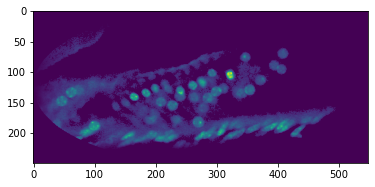

In [200]:
plt.imshow(ci.image*ci.mask0)

In [201]:
print(f"A0:\t {ci.snr0:.3f} \nkc0:\t {ci.kc0:.3f} ")

A0:	 0.615 
kc0:	 0.119 


In [203]:
w = ci.max_geomean()

/home/guillaume/miniconda3/envs/ijpy/lib/python3.7/site-packages/ipykernel_launcher.py:150: OptimizeWarning: Unknown solver options: xtol


In [204]:
w

     fun: 0.5108900084704369
 message: 'Solution found.'
    nfev: 20
  status: 0
 success: True
       x: 3.2309084099443366

In [205]:
ws = np.logspace(0, np.log10(ci.max_width), 100)
cost = np.array([ci.filtered_decorr(w) for w in ws])

(0.0, 1.0)

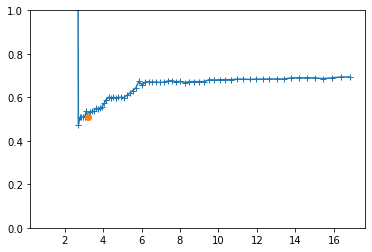

In [206]:
fig, ax = plt.subplots()

ax.plot(ws, cost, '-+')
#ax.set_xscale('log')
ax.plot(w.x, w.fun, 'o')
ax.set_ylim(0, 1)

In [207]:
ci.resolution

5.558964816409022

In [208]:
ws[np.argmin(cost)]

2.7131723565787276

In [209]:
(ci.kc * ci.snr)**0.5

0.4891099915295631

In [190]:
radii, ds, widths, snrs, kcs = ci.all_corcoefs(ci.im_fftr, 50, 0.01, 1.0, num_ws=40)


/home/guillaume/miniconda3/envs/ijpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


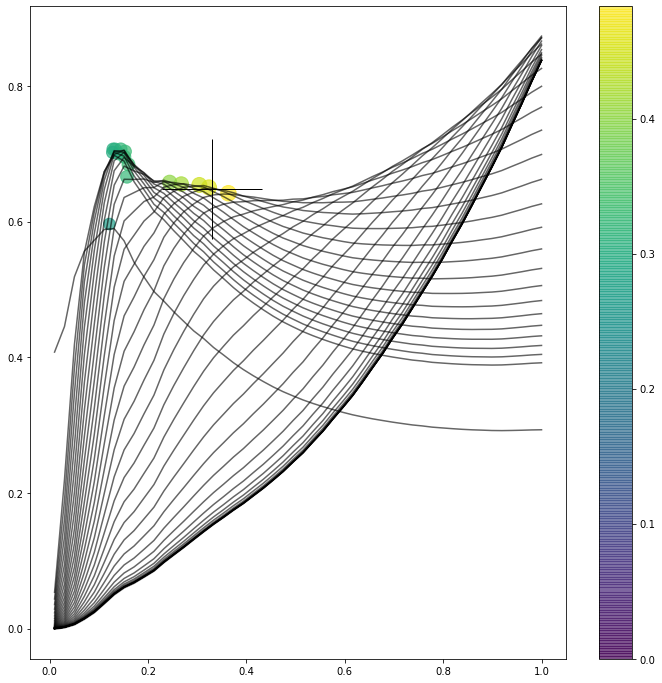

In [191]:
fig, ax = plt.subplots()
gmean = (np.array(snrs)*np.array(kcs))**0.5

sc = ax.scatter(np.array(kcs), np.array(snrs), alpha=0.7, s=gmean*500, c=gmean)

ax.plot(ci.kc, ci.snr, 'k+', ms=100)
for d in ds:
    ax.plot(radii, d, 'k-', alpha=0.6)

#ax.set_ylim(0.4, 1.0)
#ax.set_xlim(0.04, 0.4)
fig.set_size_inches(12, 12)
fig.colorbar(sc)

TypeError: can't multiply sequence by non-int of type 'list'

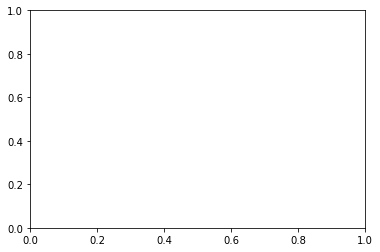

In [193]:
fig, ax = plt.subplots()

ax.scatter(widths, (kcs*snrs)**0.5)
ax